In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Python file with supporting functions
import model_utils

2023-01-10 14:40:15.551367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
recon_model_path = '/home/julias/MLEE-final-project/models/saved_models/recon_models'

### To Set and Track Seeds for Reproducibility (Referencing Group Standard):

In [3]:
ens = 'CESM'
member = '009'
reference_output_dir = '/home/julias/MLEE-final-project/pickle_files'

path_seeds = f'{reference_output_dir}/random_seeds.npy'
random_seeds = np.load(path_seeds)  

path_loc = f'{reference_output_dir}/cesm_seed_loc_dict.pickle'
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)
seed_loc = seed_loc_dict[ens][member]

# for next project, where train and test datasets use all CESM members
#path_cesm = f"{reference_output_dir}/cesm_members_dict.pickle"
#with open(path_cesm,'rb') as handle:
#    cesm_mems_dict = pickle.load(handle)

In [ ]:
# random_seeds

In [ ]:
# seed_loc_dict # using CESM 009, so seed_loc should be 32

In [ ]:
# seed_loc #confirmed 32

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [4]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

Check that data was saved and loaded properly:

In [ ]:
X_train_df

In [ ]:
y_test_df

### Create Numpy Arrays for Original Data

In [ ]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [ ]:
#X_df_norm = (X_df - X_df.mean())/X_df.std() 
#y_df_norm = (y_df - y_df.mean())/y_df.std()
#X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
#y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
#X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
#y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

CHANGE METHOD TO BELOW
- This way, time and lat/lon conversions are not normalized
- Note that coordinates don't seem to be input into ML algorithms, so T0,T1,A,B,C are the inputs of time and space (as would want, don't want two forms of time and space input)

In [5]:
#X_df_norm = X_df
#y_df_norm = y_df
#X_train_df_norm = X_train_df
#y_train_df_norm = y_train_df
#X_test_df_norm = X_test_df
#y_test_df_norm = y_test_df

#for df in X_df_norm, X_train_df_norm, X_test_df_norm:
#    df.SSS = (df.SSS - df.SSS.mean())/df.SSS.std() 
#    df.SST = (df.SST - df.SST.mean())/df.SST.std() 
#    df.MLD = (df.MLD - df.MLD.mean())/df.MLD.std() 
#    df.Chl = (df.Chl - df.Chl.mean())/df.Chl.std() 
#    df.XCO2 = (df.XCO2 - df.XCO2.mean())/df.XCO2.std() 

#for df in y_df_norm, y_train_df_norm, y_test_df_norm:
#    df.pCO2 = (df.pCO2 - df.pCO2.mean())/df.pCO2.std() 

In [ ]:
X_train_df_norm

## Create Numpy Arrays 

In [ ]:
X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

# Preliminary XGB Models

***Goal: Compare auto-XGB with lowest end and highest end of group XGB parameter matrix***

## Baseline Model Test

Alternations should at least improve on the baseline set by the auto-generated XGB algorithm

In [8]:
model_baseline = xgb.XGBRegressor(verbosity=0) 

In [9]:
model_baseline.fit(X_train_df, y_train_df)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Learning rate looks high, may need to manually set

In [10]:
train_score_baseline = model_baseline.score(X_train_df, y_train_df) 
train_score_baseline

0.9513665434481153

In [11]:
test_score_baseline = model_baseline.score(X_test_df, y_test_df) 
test_score_baseline

0.9163440706104468

In [12]:
y_pred_baseline = model_baseline.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_baseline)
print("MSE: %.2f" % mse)

MSE: 134.11


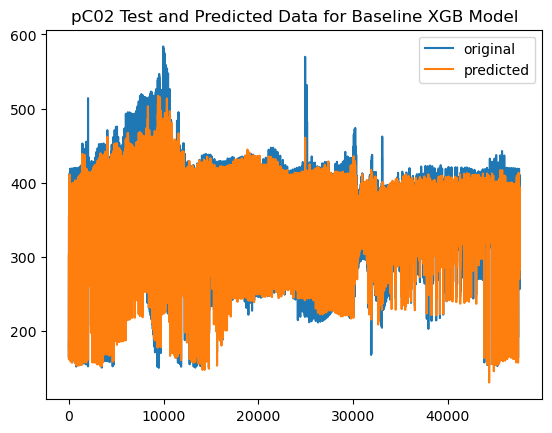

In [14]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_baseline, label="predicted")
plt.title("pC02 Test and Predicted Data for Baseline XGB Model")
plt.legend()
plt.show()

In [ ]:
y_test_df_norm['baseline_XGB_pred'] = y_pred_baseline

In [ ]:
y_test_df_norm.baseline_XGB_pred

In [ ]:
y_test_df = y_test_df.pCO2

In [ ]:
y_test_df

In [15]:
joblib.dump(model_baseline, os.path.join(recon_model_path,'XGB_prelim_baseline.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_baseline.h5']

In [16]:
baseline_load_test = joblib.load(os.path.join(recon_model_path,'XGB_prelim_baseline.h5'))

In [17]:
baseline_load_test.score(X_train_df, y_train_df)

0.9513665434481153

## Lowest Combination of XGB Parameter Matrix

In [18]:
model_low = XGBRegressor(n_estimators=3000, max_depth=5) #if want to set learning rate, eta: "often set to small values such as 0.3, 0.1, 0.01, or smaller"
model_low.fit(X_train_df, y_train_df) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [19]:
joblib.dump(model_low, os.path.join(recon_model_path,'XGB_prelim_lowest_param.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_lowest_param.h5']

In [20]:
model_low = joblib.load(os.path.join(recon_model_path,'XGB_prelim_lowest_param.h5'))

In [21]:
train_score_low = model_low.score(X_train_df, y_train_df) 
train_score_low

0.9937757645578723

In [22]:
test_score_low = model_low.score(X_test_df, y_test_df) 
test_score_low

0.9367673550262187

In [23]:
y_pred_low = model_low.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_low)
print("MSE: %.2f" % mse)

MSE: 101.37


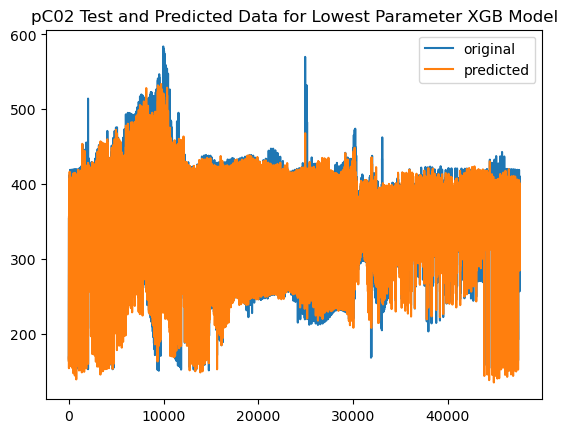

In [27]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_low, label="predicted")
plt.title("pC02 Test and Predicted Data for Lowest Parameter XGB Model")
plt.legend()
plt.show()

## Highest Combination of XGB Parameter Matrix

In [25]:
model_high = XGBRegressor(n_estimators=5000, max_depth=8)
model_high.fit(X_train_df, y_train_df) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [26]:
joblib.dump(model_high, os.path.join(recon_model_path,'XGB_prelim_highest_param.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_highest_param.h5']

In [28]:
model_high = joblib.load(os.path.join(recon_model_path,'XGB_prelim_highest_param.h5'))

In [29]:
train_score_high = model_high.score(X_train_df, y_train_df) 
train_score_high

0.9999247559832833

In [30]:
test_score_high = model_high.score(X_test_df, y_test_df) 
test_score_high

0.9371849899281297

In [31]:
y_pred_high = model_high.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_high)
print("MSE: %.2f" % mse)

MSE: 100.70


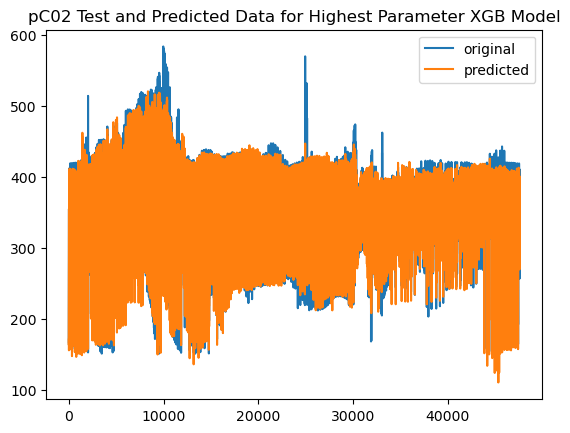

In [32]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_high, label="predicted")
plt.title("pC02 Test and Predicted Data for Highest Parameter XGB Model")
plt.legend()
plt.show()

In [ ]:
best_params = {}
model = xgb.XGBRegressor(verbosity=0,njobs=30) 
xg_param_grid = {'n_estimators':[3000, 4000, 5000],
                 'max_depth':[5, 6, 7]}
grid = GridSearchCV(model, xg_param_grid, scoring='neg_mean_squared_error') #, cv=K_folds, return_train_score=False, refit=False
grid.fit(X_train_df, y_train_df)
best_params[ens] = grid.best_params_
print(best_params)

# XGB Model

## Build XGB Model 
(based on best parameters found in previous section)

## Train XGB Model

## Save XGB Model

## Test XBG Model

# For Future Work

## Additional Validation Split 

*Note: Group does not use this method when test years are used (as I did in processed_data_split.ipynb)*

### Group's Version

#### Train/validate/test split proportions

In [ ]:
# 20% of dataset for validation, 20% of dataset for testing, the rest for training
# Training set will be split into validation and another training set

val_prop = .2
test_prop = .2

In [ ]:
# Splitting the training data into validation and another training set   
N = X_train.shape[0]
train_val_idx, train_idx, val_idx, test_idx = model_utils.train_val_test_split(N, test_prop, val_prop, random_seeds, seed_loc)
X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = model_utils.apply_splits(X_train, y_train, train_val_idx, train_idx, val_idx, test_idx) 

## Starting New Version

In [ ]:
X_minitest = X_df #.to_numpy()
y_minitest = y_df #.to_numpy()

In [ ]:
xtrain_minitest, xtest_minitest, ytrain_minitest, ytest_minitest=train_test_split(X_minitest, y_minitest, test_size=0.15)

In [ ]:
xtrain_minitest.max()

In [ ]:
xtrain_minitest

In [ ]:
XGB_model_minitest = xgb.XGBRegressor(verbosity=0) 

In [ ]:
XGB_model_minitest.fit(xtrain_minitest, ytrain_minitest)

# eXtreme Gradient Boosting 

(to compare performance to other methods from group)

In [ ]:
# For next step of testing new hyperparameters, clear best_params
# best_params = {}  # opened above

In [ ]:
# A, B and C represent lon and lat (3 components of the n-vector; so that the algorithm doesn't interpret 0 and 360
# degrees to be far apart 
# T0 and T1 represent time

#features_sel = ['SSS','SST','MLD','Chl','XCO2','T0', 'T1','A', 'B', 'C'] 
#target_sel = ['pCO2'] 

## Building and Training the XGB Model

In [ ]:
# Number of cores you have access to for model training, group standard:
jobs = 30

### Create two dictionaries

In [ ]:
test_performance = defaultdict(dict)
unseen_performance = defaultdict(dict)

### XGB-Specific Inputs

In [ ]:
# K_folds: cross validation; number of splits for training set (in this case 3 splits; see below)
# Train on the first split, test on the remaining 2. Total 3 numbers for the final RMSE

K_folds = 3       # Split training set into 3 parts
approach = "xg"   # XGB approach
#first_mem = False # Initialize if using gridsearch to find best_params

In [ ]:
# model: define which approach to use
# param_grid: the n_estimators (decision trees) and depths
# GridSearchCV: applying the K-fold cross validation
# first_mem = False: checks only the best params for first_mem (and not all members). For the next members, the  
# parameters from first_mem are re-used
# you could try to find the best params for a few members (but not all of them)
# 9 possible combinations (3 different n_estimators, 3 different max depths) x 3 (K-fold; 3 training sets)
if first_mem:
            model = XGBRegressor(random_state=random_seeds[4,seed_loc], n_jobs=jobs)
            param_grid = xg_param_grid
            grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=False)
            grid.fit(X_train_val, y_train_val)
            best_params[ens] = grid.best_params_
            print(best_params)
            first_mem = False

In [ ]:
model = XGBRegressor(random_state=random_seeds[4,seed_loc], n_jobs=jobs)
param_grid = xg_param_grid
grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=False)
grid.fit(X_train, y_train)
best_params[ens] = grid.best_params_
print(best_params)

### Train the XGB model

In [ ]:
model = XGBRegressor(random_state=random_seeds[5,seed_loc], **best_params[ens], n_jobs=jobs)
model.fit(X_train_val, y_train_val) 

### Save the XGB model

In [ ]:
#Uncomment when actually running

# pre_saildrone now called utils, carry through this change
utils.save_model(model, recon_model_path, approach, ens, member)
print(datetime.datetime.now())
print(ens)
print(member)

## Test the XGB Model

### Preliminary Analysis on XBG Test Error Metrics

In [ ]:
# Calculate some test error metrics and store in a dictionary
# evaluate_test is a function from pre_saildrone. it includes MSE, MAE, bias etc

y_pred_test = model.predict(X_test)

test_performance[ens][member] = utils.evaluate_test(y_test, y_pred_test)
print(test_performance[ens][member])

In [ ]:
# Redo this analysis on the unseen data
y_pred_unseen = model.predict(df.loc[unseen_sel,features_sel].to_numpy())

y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = utils.evaluate_test(y_unseen, y_pred_unseen)
print(unseen_performance[ens][member])

## Create the reconstruction

In [ ]:
# Create the reconstruction and save it
# Jake calls it seen
# This should just be all SOCAT locations for all training years (not test years)
y_pred_seen = model.predict(X)

In [ ]:
# Full reconstruction 
df['pCO2_DIC_recon'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_recon']] = y_pred_unseen   # Not in a SOCAT location, not even in test year
df.loc[sel,['pCO2_DIC_recon']] = y_pred_seen

In [ ]:
# All time/locations not sampled by SOCAT
df['pCO2_DIC_nosocat'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_nosocat']] = y_pred_unseen
df.loc[sel,['pCO2_DIC_nosocat']] = np.nan

In [ ]:
# Only at time/locations of SOCAT sampling
df['pCO2_DIC_socat'] = np.nan
df.loc[unseen_sel,['pCO2_DIC_socat']] = np.nan
df.loc[sel,['pCO2_DIC_socat']] = y_pred_seen
     
df['pCO2_DIC'] = df['pCO2_pCO2T_diff']
             
#DS_recon = df[['net_mask','socat_mask','pCO2_DIC','pCO2_DIC_recon','pCO2_DIC_socat','pCO2_DIC_nosocat']].to_xarray()
DS_recon = df[['net_mask','combined_mask','pCO2_DIC','pCO2_DIC_recon','pCO2_DIC_socat','pCO2_DIC_nosocat']].to_xarray()

## Save reconstructions

In [ ]:
# Uncomment when actually running            
#pre_saildrone_thea.save_recon(DS_recon, recon_output_dir, approach, ens, member)   

## Save best parameters and performance metrics

In [ ]:
# Saving best parameters and performance metrics

approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
test_perform_fname = f"{approach_output_dir}/{approach}_test_performance_dict.pickle"
unseen_perform_fname = f"{approach_output_dir}/{approach}_unseen_performance_dict.pickle"

Path(approach_output_dir).mkdir(parents=True, exist_ok=True)

with open(param_fname, 'wb') as handle: #WHAT DOES wb MEAN
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(test_perform_fname, 'wb') as handle:
    pickle.dump(test_performance, handle)
with open(unseen_perform_fname, 'wb') as handle:
    pickle.dump(unseen_performance, handle)
    
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]
                                  for i in test_performance.keys()
                                  for j in test_performance[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]
                                  for i in unseen_performance.keys()
                                  for j in unseen_performance[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)    

In [ ]:
#just checking what the saved trained datafiles look like 
test_2 = pd.read_pickle("/data/artemis/workspace/theimdal/saildrone/models/trained/xg/CESM/member_016/xg_model_pC02_2D_mon_CESM_016_1x1_198201-201701.joblib")

In [ ]:
test_2

In [ ]:
#checking out what the input data for the XGB looks like
#this table was generated in script 01
df